<a href="https://colab.research.google.com/github/GwiHwan-Go/Reproduce_CutMix/blob/main/Training/CutMix_baseline_tinyImagenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200

--2022-05-18 17:21:18--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  5.75MB/s    in 57s     

2022-05-18 17:22:21 (4.12 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [1]:
import json
import os
import torch


In [5]:

training_data_list = []
for folder in os.listdir('./tiny-imagenet-200/train/'):
  label = folder  # The name of the folder is the label of the images it contains
  for file in os.listdir('./tiny-imagenet-200/train/' + folder + '/images/'):
    file_dir = './tiny-imagenet-200/train/' + folder + '/images/' + file
    training_data_list.append((file_dir, label))
with open('./training_data_list.json', 'w') as f:
  json.dump(training_data_list, f)

testing_data_list = []
with open('./tiny-imagenet-200/val/val_annotations.txt', 'r') as f:
  for line in f.readlines():
    file, label = line.split()[0:2]
    file_dir = './tiny-imagenet-200/val/images/' + file
    testing_data_list.append((file_dir, label))

with open('./testing_data_list.json', 'w') as f:
  json.dump(testing_data_list, f)

In [2]:
with open('./tiny-imagenet-200/wnids.txt', 'r') as f :
  label_id = f.readlines()
label_id = [i[:-1] for i in label_id]
len(label_id)

200

In [3]:

from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data.dataloader import *
import cv2 # OpenCV


In [4]:
class TinyImageDataset(Dataset):
  def __init__ (self, data, transform) :
    
    self.data = data
    self.transform = transform

  def __getitem__(self, index):
    img_path, label = self.data[index]
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) 
    if self.transform is not None:
      img = self.transform(img)
    return img, label_id.index(label)

  def __len__(self):
    return len(self.data)

In [5]:
file_name='./training_data_list.json'
with open(file_name, 'r') as f:
  data = json.load(f)

In [6]:
batch_size = 256
transform = transforms.Compose(
    [transforms.ToTensor()])

In [7]:
from sklearn.model_selection import train_test_split


train_dataset = TinyImageDataset(data = data, transform = transform)
train_set, valid_set = train_test_split(train_dataset, test_size=0.2)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

batch = next(iter(train_loader))
images, labels = batch


In [8]:
import matplotlib.pyplot as plt
import torchvision

plt.figure(figsize=(12,12))
grid = torchvision.utils.make_grid(tensor=images, nrow=4) # nrow = number of images displayed in each row

print(f"class labels: {labels}")

# Use grid.permute() to transpose the grid so that the axes meet the specifications required by 
# plt.imshow(), which are [height, width, channels]. PyTorch dimensions are [channels, height, width].
plt.imshow(grid.permute(1,2,0))

class labels: tensor([ 93, 190,  10,  28, 158, 197,  23, 121, 101, 123, 159,  32,  28,  24,
        177,  19,  16,  58,  90,  14, 107,  87, 150,   5,  85, 193, 132, 100,
        158, 100, 126, 197,  38, 167,  86, 156, 123, 191,  17,  31,  87,  35,
         45, 182, 104, 180, 116, 149, 105,  96,  82,  28, 142,  63, 199, 136,
         36, 132, 129,  30, 151,  73,  31, 199, 188,  79, 158, 141, 146, 197,
        138,  34, 141, 136,  86, 187,  36,  37,  96, 127,  67,  77,  48, 140,
         90, 196, 125, 179,  92, 113,  40,  85, 142, 153,  88,  72, 188,  46,
        190,  42,  54, 152,  77, 156, 151,  24,  77,  70,  34,  55, 194, 179,
        128, 106, 175,  97, 182,  15, 124,  66,  78,  56,  26, 123, 142, 112,
        192, 151,  89, 150,  94,  99,  44,  25,  40,  85, 119, 162,  81,  88,
        193,  57,  97, 128,  31,  86,  48, 122, 121, 195,  84,  64,  25, 166,
          8,  60, 174,  84,  94,  42,  73,   4,  23, 117,  95,  78, 159, 105,
         77, 109,  59, 105, 178,   8,  63,  91, 14

In [9]:
import numpy as np

def cut(W,H,lam):
        
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

In [10]:
images, labels = next(iter(train_loader))
rand_index = torch.randperm(images.shape[0])
shuffled_images = images[rand_index]
lam = np.random.beta(1.0, 1.0)
cutmix_images = images.clone().detach()
cutout_images = images.clone().detach() 
mixup_images = images.clone().detach() 

bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix

In [11]:
## CUTMIX ##
cutmix_images[:, :, bbx1:bbx2, bby1:bby2] = cutmix_images[rand_index, :, bbx1:bbx2, bby1:bby2]
## CUTOUT ##
cutout_images[:, :, bbx1:bbx2, bby1:bby2] = 0.
## MIXUP ##
mixup_images = lam * mixup_images + (1 - lam) * mixup_images[rand_index,:,:]

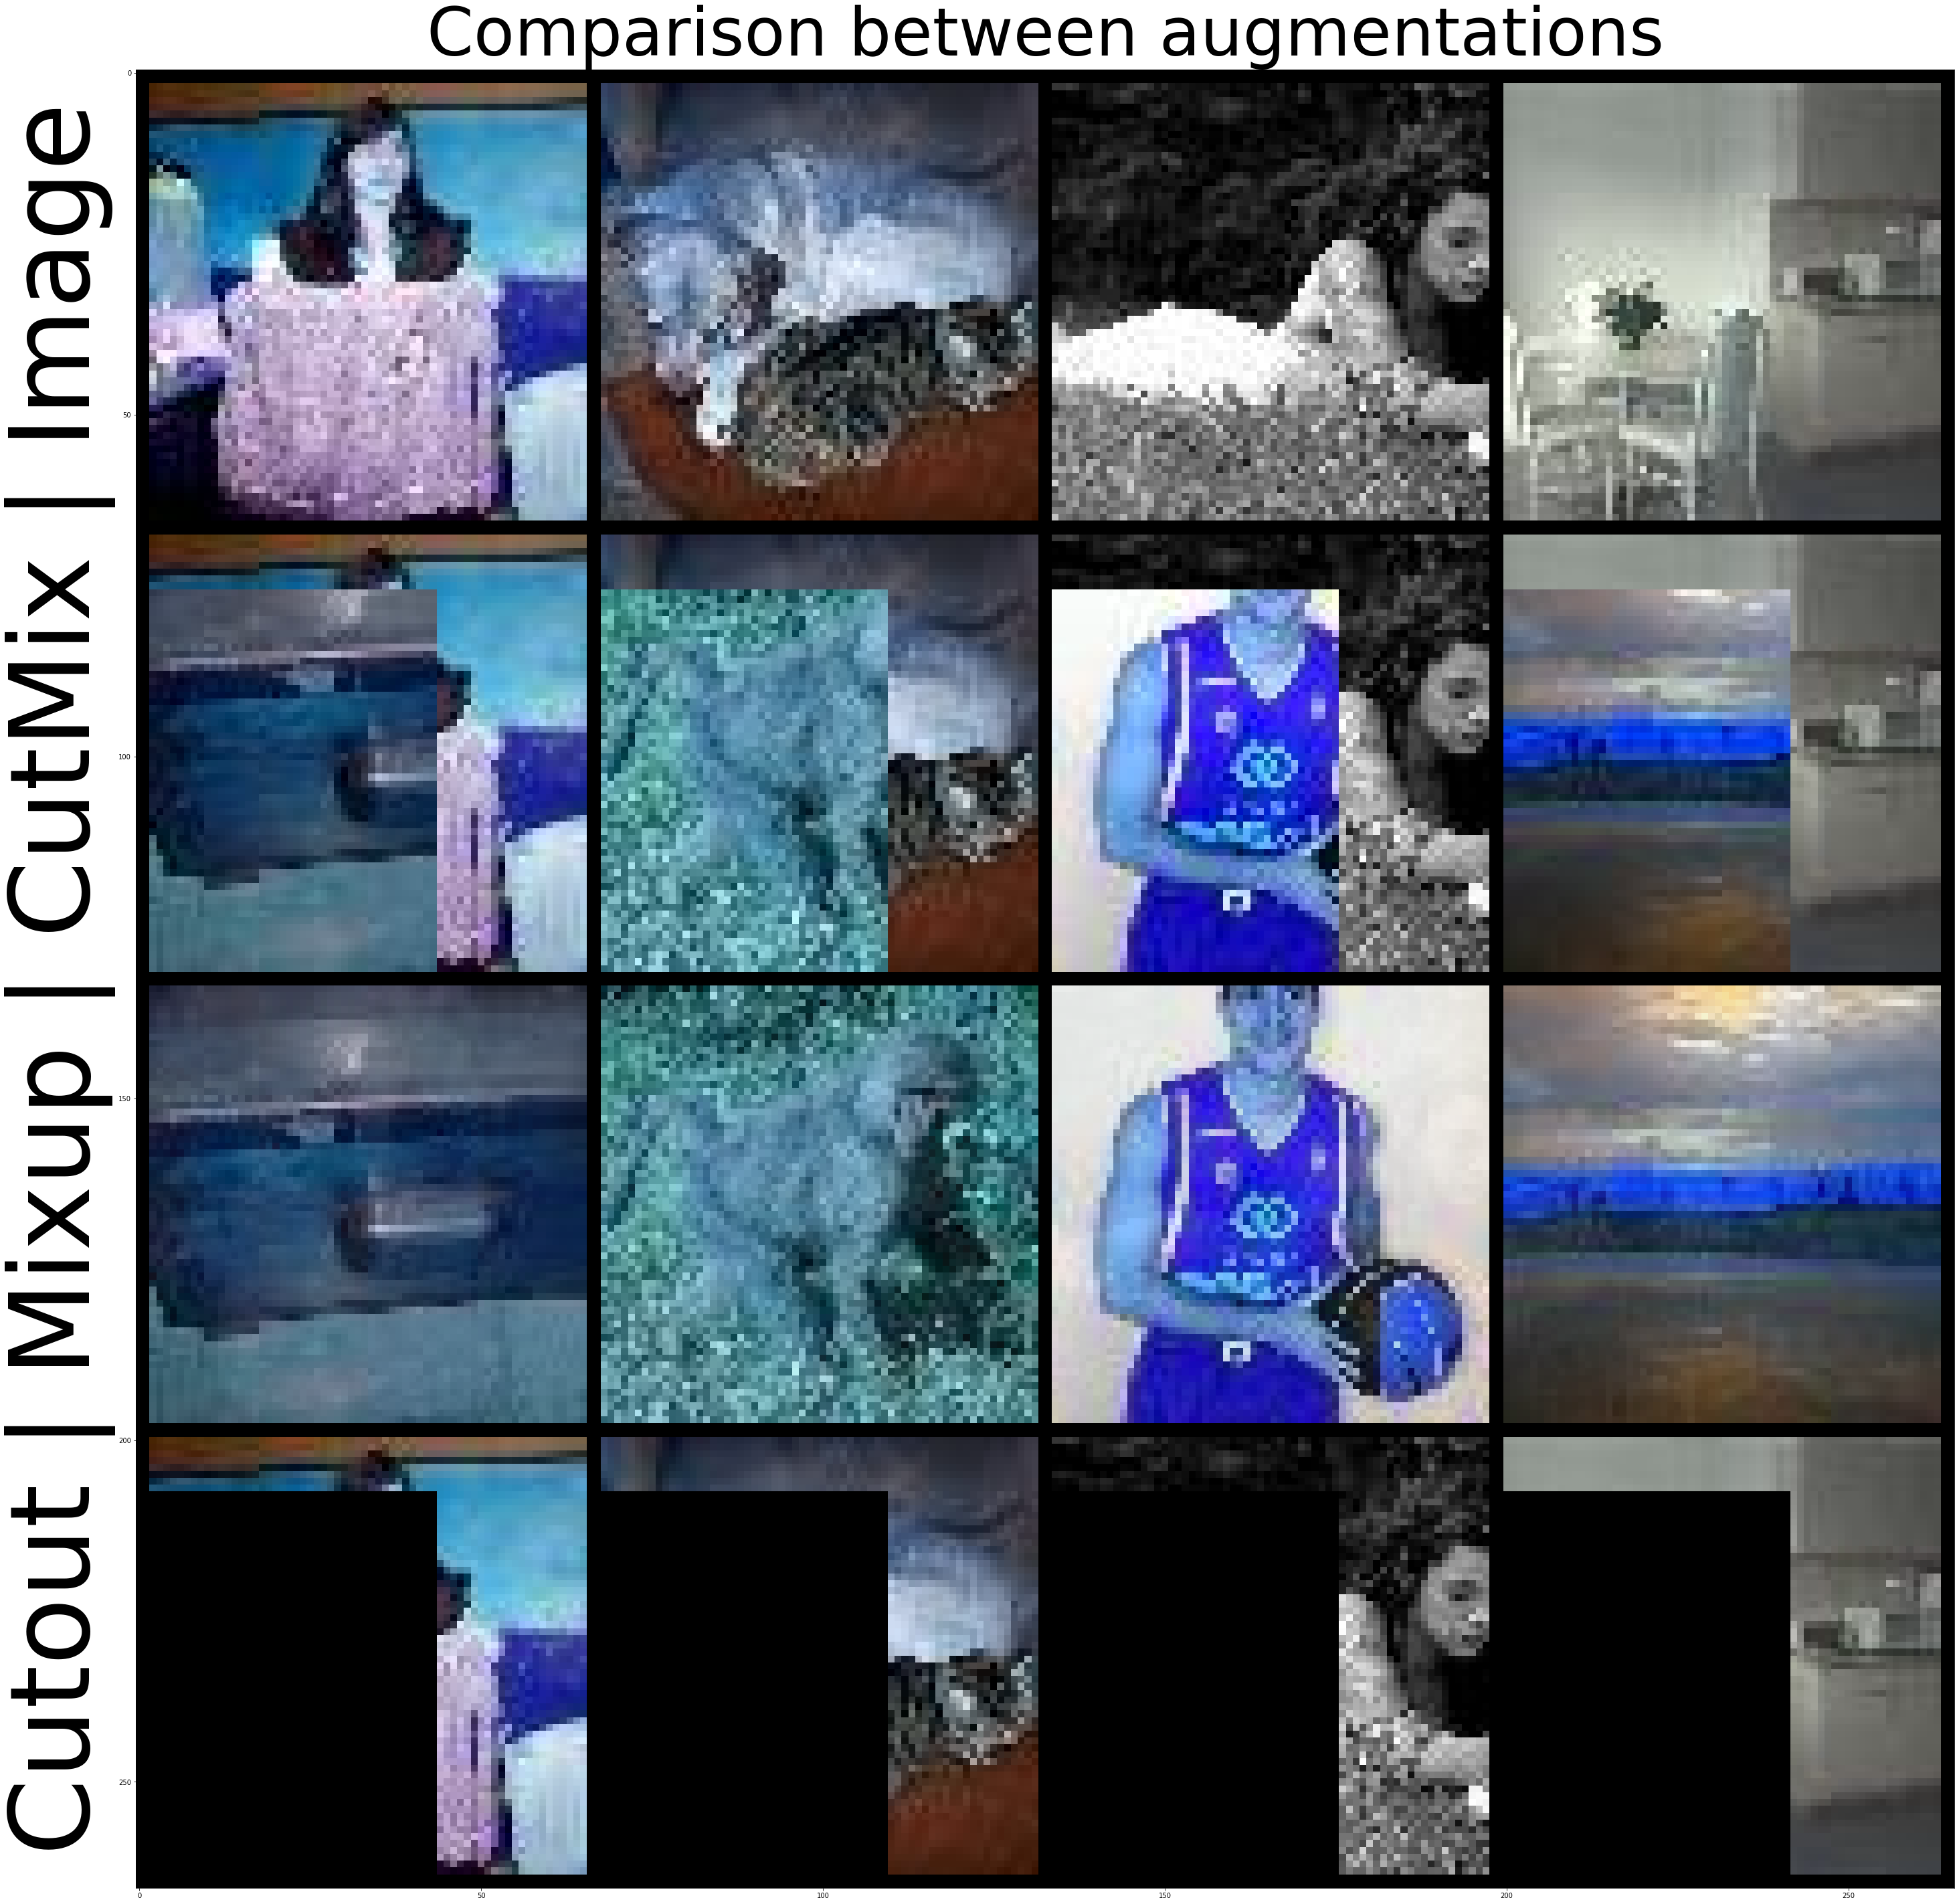

In [12]:
  
def show_cutMixed_compare(row1, row2, row3, row4, nums_show):
    rand_index = torch.randperm(row1.size()[0])[:nums_show]
    to_compare = torch.cat([row1[rand_index,:,:],row2[rand_index,:,:],row3[rand_index,:,:],row4[rand_index,:,:]],dim=0)
    plt.figure(figsize=(50,50))
    grid = torchvision.utils.make_grid(tensor=to_compare, nrow=nums_show)
    plt.ylabel("Cutout | Mixup | CutMix | Image",fontsize=165, rotation = 90)
    plt.title("Comparison between augmentations", fontsize=100)
    plt.imshow(grid.permute(1,2,0))

show_cutMixed_compare(images, cutmix_images, mixup_images, cutout_images, 4)

In [13]:
from torch.nn import Linear
from torchvision import models

# VGG16 Model Loading
use_pretrained = True
model = models.resnet50(pretrained=use_pretrained)
## 우리 이미지 사이즈에 맞게 튜닝

model.fc = torch.nn.Linear(2048, len(labels)) 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

cuda


In [ ]:
import torch.optim as optim
import torch.nn as nn
from tqdm.auto import tqdm, trange

def get_accuracy(model, dataloader):
    correct = 0
    total = 0
    model.eval() # For later #
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return 100.0 * correct / total

def train_model(model, 
                train, 
                valid, 
                resume_loss = None,
                resume_iters = None,
                n_iters=500, 
                learn_rate=0.01, 
                weight_decay=0, 
                which_method=0):  # Lists to store model's performance information

###############Checkpoint Zone################
  PATH="./checkpoint.pt"
  if resume_loss is not None :
    criterion = resume_loss
  else :
    criterion = nn.CrossEntropyLoss()
  if resume_iters is not None :
    num_epochs = resume_iters
  else :
    num_epochs = n_iters
###############Checkpoint Zone###############

  for i in trange(num_epochs):
    try :
      for images, labels in tqdm(train) :
        images, labels = images.to(device), labels.to(device)
        model.train() # For Dropout and Batch Norm layers #

        if which_method and (np.random.rand()<0.5) :

          lam = np.random.beta(1.0, 1.0)
          rand_index = torch.randperm(images.size()[0])
          shuffled_labels = labels[rand_index]

          ##############Do Something On Data###############
          if which_method == 1 : ##cutmix
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2] #cut and mix
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.shape[-1] * images.shape[-2]))
          if which_method == 2 : ##mixup
            images = lam * images + (1 - lam) * images[rand_index,:,:]
          if which_method == 3 : ##cutout
            bbx1, bby1, bbx2, bby2 = cut(images.shape[2], images.shape[3], lam) # define a box to cut and mix
            images[:, :, bbx1:bbx2, bby1:bby2] = 0.
          ##############Do Something On Data###############

          #############Forward Pass##############
          out = model(images) 
          #############Forward Pass##############

          ##############Modify Loss Function###############
          if which_method == 1 : ##cutmix
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam) # compute the total loss
          if which_method == 2 : ##mixup
            loss = criterion(out, labels) * lam + criterion(out, shuffled_labels)*(1.0-lam)
          if which_method == 3 : ##cutout
            loss = criterion(out, labels)
          ##############Modify Loss Function###############

        else : ## if random.rand > 0.5 or which_method == 0
          
          out = model(images)
          loss = criterion(out, labels)

        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # reset the gradients for the next iteration
    except :
      torch.save({'total_epochs':num_epochs, 'epoch': i, 'model_state_dict': model.state_dict(), 'loss': loss}, PATH)
      print(f"Successfully saved untill {i-1} step in {PATH} with model, optimizer, and loss.")
      return 0

In [37]:
train_model(model, train_loader, valid_loader, n_iters=3, 
                    learn_rate=0.001, 
                    weight_decay=0, which_method=2) 

#which method 0 : nothing, 1: cutmix, 2: mixup 3: cutout


Successfully saved untill 1 step in ./checkpoint.pt with model, optimizer, and loss.


0

In [ ]:
## Chek point load 요령 ##
PATH="./checkpoint.pt"
optimizer = optim.SGD(model.parameters(), lr=0.01)
checkpoint = torch.load(PATH) 
epoch = checkpoint['total_epochs'] - checkpoint['epoch'] 
criterion = checkpoint['loss']
train_model(model.load_state_dict(checkpoint['model_state_dict']), 
                    train_loader, valid_loader, n_iters=3, 
                    learn_rate=0.001, 
                    resume_loss=checkpoint['loss'],
                    resume_iters=checkpoint['total_epochs'] - checkpoint['epoch'],
                    weight_decay=0, which_method=2) 

AttributeError: '_IncompatibleKeys' object has no attribute 'state_dict'

In [ ]:
model.load_state_dict(checkpoint['model_state_dict']).parameters()

https://github.com/facebookresearch/mixup-cifar10/blob/main/train.py